In [53]:
from collections import namedtuple, OrderedDict

import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from nengo_learn_assoc_mem.utils import meg_from_spikes, numpy_bytes_to_str

In [11]:
with h5py.File("../data/neg_voja_enc.h5", "r") as fi:
    print(list(fi.keys()))

    fan1 = numpy_bytes_to_str(fi['fan1'])
    fan2 = numpy_bytes_to_str(fi['fan2'])
    foil1 = numpy_bytes_to_str(fi['foil1'])
    foil2 = numpy_bytes_to_str(fi['foil2'])
    
    dt = fi["t_range"].attrs["dt"]

['encoders', 'fan1', 'fan2', 'foil1', 'foil2', 't_range', 'vocab_strings', 'vocab_vectors']


In [2]:
experiments = ("base", "higher_thresh", "less_base_inhib", "long_pause", "more_repeats")

In [5]:
with h5py.File("../data/neg_voja_rec_learn/base.h5") as fi:
    print(list(fi.keys()))

['spike_response', 'train_spikes', 'w_hist']


## Compare responses

In [59]:
responses = []
MegResp = namedtuple("MegResp", ["name", "t_pause", "t_present", "spike_response"])

for exp in experiments:
    print(exp)
    with h5py.File(f"../data/neg_voja_rec_learn/{exp}.h5", "r") as fi:
        responses.append(
            MegResp(
                exp,
                fi["w_hist"].attrs["t_pause"],
                fi["w_hist"].attrs["t_present"],
                meg_from_spikes(fi["spike_response"])
            )
        )

base
higher_thresh
less_base_inhib
long_pause
more_repeats


MegResp(name='base', t_pause=0.1, t_present=0.3, spike_response=array([ 0.        ,  0.        ,  0.        , ..., 78.92015952,
       78.13489081, 77.35743566]))
MegResp(name='higher_thresh', t_pause=0.1, t_present=0.3, spike_response=array([ 0.        ,  0.        ,  0.        , ..., 78.92016002,
       78.13489131, 77.35743615]))
MegResp(name='less_base_inhib', t_pause=0.1, t_present=0.3, spike_response=array([  0.        ,   0.        ,   0.        , ..., 264.37760364,
       261.74700253, 259.14257634]))
MegResp(name='long_pause', t_pause=0.3, t_present=0.3, spike_response=array([ 0.        ,  0.        ,  0.        , ..., 10.47194317,
       10.3677456 , 10.2645848 ]))
MegResp(name='more_repeats', t_pause=0.1, t_present=0.3, spike_response=array([ 0.        ,  0.        ,  0.        , ..., 78.92018846,
       78.13491946, 77.35746402]))


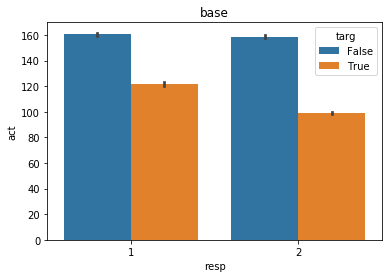

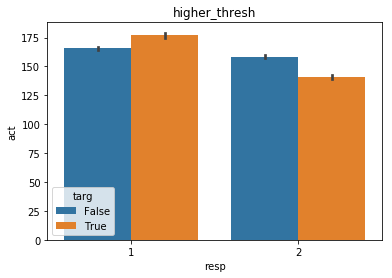

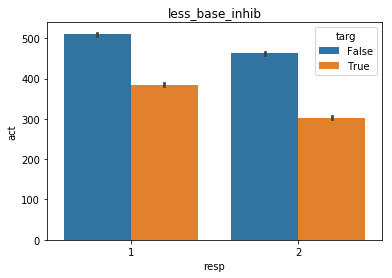

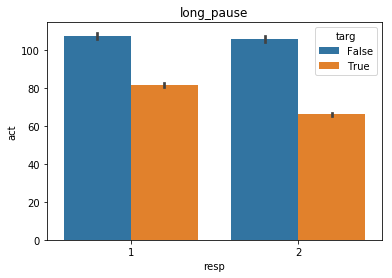

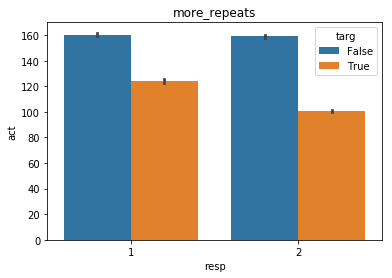

In [62]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'slc'])

for meg_resp in responses:
    
    df_list = []
    
    t_pause = meg_resp.t_pause
    t_present = meg_resp.t_present
    
    t_each = t_pause + t_present
    td_pause = int(t_pause / dt)
    td_each = int(t_each / dt)
    
    fan1_slc = slice(td_pause, td_each*len(fan1)+td_pause)
    fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2))
    foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1))
    foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2))

    slc_stim_vecs = {"fan1": SlcStim(1, True, fan1_slc),
                     "fan2": SlcStim(2, True, fan2_slc),
                     "foil1": SlcStim(1, False, foil1_slc),
                     "foil2": SlcStim(2, False, foil2_slc)}

    for key, obj in slc_stim_vecs.items():
        act = meg_resp.spike_response[obj.slc]
        resp = [obj.fan_num] * len(act)
        targ = [obj.targ] * len(act)
        df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

    act_df = pd.concat(df_list)
    
    plt.figure()
    plt.title(meg_resp.name)
    sns.barplot(x="resp", y="act", hue="targ", data=act_df) 